# Trend Following Strategy

This notebook answers question 3.4 form the text book Advances in Financial Machine Learning.

3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [1, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {-1, 1}.

I took some liberties by extending the features to which I use to build the meta model. I also add some performance metrics at the end. 

In conclusion: Meta Labeling works, SMA strategies suck.

In [1]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [2]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


### Create the data 

In [3]:
orig_data_file = r"C:\Users\as250199\nifty50\2017_individual_files\BANKNIFTY_F1_2017.csv"
file_2018 = r"C:\Users\as250199\nifty50\2018_individual_files\BANKNIFTY_F1_2018.csv"

orig_df = pd.read_csv(orig_data_file)
df_2018 = pd.read_csv(file_2018)


orig_df['DATE'] = orig_df['DATE'].astype(str)
df_2018['DATE'] = df_2018['DATE'].astype(str)

orig_df = pd.concat([orig_df, df_2018], axis=0)
orig_df.head()

orig_df.shape

(155873, 8)

Based on the datacreation, we need only 3 columns 
1. data + time 
2. Price 
3. Volumn 

Now price I will take as the closing price for each minute. 


In [4]:

date_time = orig_df['DATE'] + ' ' + orig_df['TIME']
new_data = pd.concat([date_time, orig_df['CLOSE'], orig_df['VOLUME']], axis=1)
new_data.columns = ['date','price','volume']
display(new_data.head())

        

,date,price,volume
0,20170403 09:16,21530.3,23800
1,20170403 09:17,21512.8,17520
2,20170403 09:18,21518.0,10560
3,20170403 09:19,21528.2,18600
4,20170403 09:20,21525.0,11440


In [5]:
new_data.columns


Index(['date', 'price', 'volume'], dtype='object')

,date,price,volume
0,2017-04-03 09:16:00,21530.3,23800
1,2017-04-03 09:17:00,21512.8,17520
2,2017-04-03 09:18:00,21518.0,10560
3,2017-04-03 09:19:00,21528.2,18600
4,2017-04-03 09:20:00,21525.0,11440


,date,price,volume
52803,2017-01-02 09:16:00,18213.3,47880
52804,2017-01-02 09:17:00,18221.8,24000
52805,2017-01-02 09:18:00,18160.0,34920
52806,2017-01-02 09:19:00,18171.9,33920
52807,2017-01-02 09:20:00,18155.1,16400


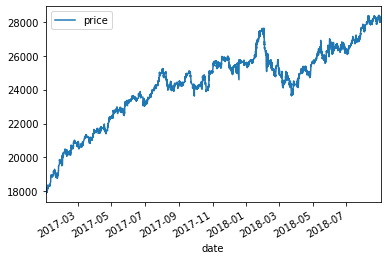

In [6]:
new_data['date'] = pd.to_datetime(new_data['date'])
display(new_data.head())
new_data.sort_values(by='date', axis=0, inplace=True)
display(new_data.head())
# plotting to confirm the data is sequential
new_data.plot(kind="line", x= "date", y="price")


In [7]:
new_data.to_csv('BANK_NIFTY_2017_DTPV.csv', index=False)

### Creating Dollar Bars

In [8]:
print('Creating Dollar Bars')
dollar = ml.data_structures.get_dollar_bars('BANK_NIFTY_2017_DTPV.csv', threshold=2000000000, batch_size=10000, verbose=True)


Creating Dollar Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Returning bars 



,date_time,open,high,low,close,volume,value
0,2017-01-02 09:19:00,18213.3,18221.8,18160.0,18171.9,140720,2.557150e+09
1,2017-01-02 09:25:00,18171.9,18171.9,18132.6,18142.9,117800,2.137234e+09
2,2017-01-02 09:31:00,18142.9,18151.4,18085.0,18085.0,124320,2.248327e+09
3,2017-01-02 09:34:00,18085.0,18085.0,18052.0,18072.8,140240,2.534529e+09
4,2017-01-02 09:45:00,18072.8,18097.2,18071.6,18083.3,111800,2.021713e+09


(13519, 7)

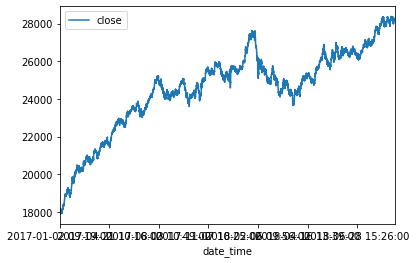

In [9]:
dollar['value'] = dollar['close'] * dollar['volume']
display(dollar.head())
display(dollar.shape)
dollar.plot(kind="line",x="date_time",y="close")

In [10]:
dollar.to_csv('BANK_NIFTY_2017_200crore_dbar.csv', index=False)

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

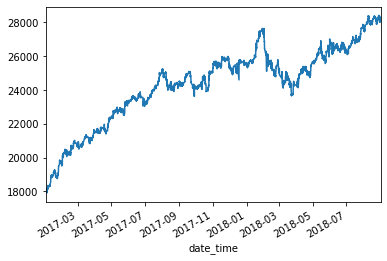

In [11]:
# Read in data
data = pd.read_csv("BANK_NIFTY_2017_200crore_dbar.csv")
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
data.head()
data['close'].plot()

In [12]:
display(data.head())
print(data.index.min())
print(data.index.max())
print(data.shape)

,open,high,low,close,volume,value
date_time,,,,,,
2017-01-02 09:19:00,18213.3,18221.8,18160.0,18171.9,140720,2.557150e+09
2017-01-02 09:25:00,18171.9,18171.9,18132.6,18142.9,117800,2.137234e+09
2017-01-02 09:31:00,18142.9,18151.4,18085.0,18085.0,124320,2.248327e+09
2017-01-02 09:34:00,18085.0,18085.0,18052.0,18072.8,140240,2.534529e+09
2017-01-02 09:45:00,18072.8,18097.2,18071.6,18083.3,111800,2.021713e+09


2017-01-02 09:19:00
2018-08-31 15:29:00
(13519, 6)


---
### Fit a Primary Model: Trend Following
Based on the simple moving average cross-over strategy.


In [13]:
# compute moving averages
fast_window = 20
slow_window = 50

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
display(data.head())

# Compute sides
data['side'] = np.nan

long_signals = data['fast_mavg'] >= data['slow_mavg'] 
short_signals = data['fast_mavg'] < data['slow_mavg'] 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

,open,high,low,close,volume,value,fast_mavg,slow_mavg
date_time,,,,,,,,
2017-01-02 09:19:00,18213.3,18221.8,18160.0,18171.9,140720,2.557150e+09,NaN,NaN
2017-01-02 09:25:00,18171.9,18171.9,18132.6,18142.9,117800,2.137234e+09,NaN,NaN
2017-01-02 09:31:00,18142.9,18151.4,18085.0,18085.0,124320,2.248327e+09,NaN,NaN
2017-01-02 09:34:00,18085.0,18085.0,18052.0,18072.8,140240,2.534529e+09,NaN,NaN
2017-01-02 09:45:00,18072.8,18097.2,18071.6,18083.3,111800,2.021713e+09,NaN,NaN


In [14]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)
display(data.head())
data.shape

,open,high,low,close,volume,value,fast_mavg,slow_mavg,side
date_time,,,,,,,,,
2017-01-03 13:17:00,18095.0,18113.9,18046.4,18046.4,131560,2.374184e+09,18049.085,18030.344,1.0
2017-01-03 13:19:00,18046.4,18046.4,18004.8,18025.0,140560,2.533594e+09,18054.390,18027.986,1.0
2017-01-03 13:23:00,18025.0,18025.0,18002.2,18005.5,115360,2.077114e+09,18060.515,18026.396,1.0
2017-01-03 13:31:00,18005.5,18029.2,17987.5,18017.2,117200,2.111616e+09,18067.100,18025.284,1.0
2017-01-03 13:47:00,18017.2,18029.8,17993.9,18009.5,114280,2.058126e+09,18071.380,18023.808,1.0


(13469, 9)

In [15]:
data['side'].value_counts()

 1.0    7530
-1.0    5939
Name: side, dtype: int64

Everything till here is perfect

### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [16]:
data.index.max()

Timestamp('2018-08-31 15:29:00')

In [17]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2017-01-01':'2018-08-31'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [18]:
display(daily_vol.head())
display(cusum_events)
print(daily_vol.mean()*0.5)
display(vertical_barriers)




date_time
2017-01-04 13:43:00         NaN
2017-01-04 14:02:00    0.000837
2017-01-04 14:10:00    0.001272
2017-01-04 14:23:00    0.001503
2017-01-04 14:40:00    0.003154
Name: close, dtype: float64

DatetimeIndex(['2017-01-03 14:22:00', '2017-01-03 14:33:00',
               '2017-01-03 15:13:00', '2017-01-04 09:21:00',
               '2017-01-04 09:37:00', '2017-01-04 10:48:00',
               '2017-01-04 11:20:00', '2017-01-04 12:04:00',
               '2017-01-04 14:02:00', '2017-01-04 14:52:00',
               ...
               '2018-08-30 09:16:00', '2018-08-30 09:20:00',
               '2018-08-30 10:02:00', '2018-08-30 12:25:00',
               '2018-08-30 13:12:00', '2018-08-30 15:09:00',
               '2018-08-31 09:16:00', '2018-08-31 09:32:00',
               '2018-08-31 10:30:00', '2018-08-31 15:12:00'],
              dtype='datetime64[ns]', length=1973, freq=None)

0.0029426570060938555


2017-01-03 14:22:00   2017-01-04 14:23:00
2017-01-03 14:33:00   2017-01-04 14:40:00
2017-01-03 15:13:00   2017-01-04 15:19:00
2017-01-04 09:21:00   2017-01-05 09:23:00
2017-01-04 09:37:00   2017-01-05 09:37:00
2017-01-04 10:48:00   2017-01-05 11:16:00
2017-01-04 11:20:00   2017-01-05 11:42:00
2017-01-04 12:04:00   2017-01-05 12:17:00
2017-01-04 14:02:00   2017-01-05 14:12:00
2017-01-04 14:52:00   2017-01-05 14:58:00
2017-01-05 09:16:00   2017-01-06 09:18:00
2017-01-05 09:33:00   2017-01-06 09:35:00
2017-01-05 12:17:00   2017-01-06 12:47:00
2017-01-06 09:18:00   2017-01-09 09:16:00
2017-01-06 09:28:00   2017-01-09 09:16:00
2017-01-06 10:00:00   2017-01-09 09:16:00
2017-01-06 10:50:00   2017-01-09 09:16:00
2017-01-06 13:44:00   2017-01-09 09:16:00
2017-01-06 14:44:00   2017-01-09 09:16:00
2017-01-09 09:24:00   2017-01-10 09:27:00
2017-01-09 10:39:00   2017-01-10 10:55:00
2017-01-09 14:07:00   2017-01-10 14:16:00
2017-01-10 09:19:00   2017-01-11 09:19:00
2017-01-10 09:36:00   2017-01-11 0

Got the vertial barrier after 1 day. Got the events where the threshold is  0.0028.

Now need to label the data for the 2 horizontal barriers.

In [19]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=8,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\mlfinlab\labeling\labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-11-13 13:17:34.984795 100.0% apply_pt_sl_on_t1 done after 0.64 minutes. Remaining 0.0 minutes.


In [20]:
triple_barrier_events

,side,t1,trgt,pt,sl
2017-01-05 12:17:00,1.0,2017-01-06 09:28:00,0.005163,1,2
2017-01-06 09:18:00,1.0,2017-01-06 10:00:00,0.005895,1,2
2017-01-06 09:28:00,1.0,2017-01-09 09:16:00,0.005747,1,2
2017-01-06 10:00:00,1.0,2017-01-09 09:16:00,0.005504,1,2
2017-01-06 10:50:00,1.0,2017-01-09 09:16:00,0.005614,1,2
2017-01-06 13:44:00,1.0,2017-01-09 09:16:00,0.005073,1,2
2017-01-09 10:39:00,1.0,2017-01-10 10:55:00,0.005108,1,2
2017-01-09 14:07:00,1.0,2017-01-10 14:16:00,0.005208,1,2
2017-01-10 09:19:00,1.0,2017-01-11 09:16:00,0.005071,1,2
2017-01-10 09:36:00,1.0,2017-01-10 15:19:00,0.005111,1,2


In [21]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    643
-1.0    562
Name: side, dtype: int64

In [22]:
labels

,ret,trgt,bin,side
2017-01-05 12:17:00,0.005956,0.005163,1,1.0
2017-01-06 09:18:00,0.007567,0.005895,1,1.0
2017-01-06 09:28:00,0.001468,0.005747,0,1.0
2017-01-06 10:00:00,-0.002058,0.005504,0,1.0
2017-01-06 10:50:00,0.000044,0.005614,0,1.0
2017-01-06 13:44:00,-0.003439,0.005073,0,1.0
2017-01-09 10:39:00,0.001391,0.005108,0,1.0
2017-01-09 14:07:00,0.000936,0.005208,0,1.0
2017-01-10 09:19:00,0.007038,0.005071,1,1.0
2017-01-10 09:36:00,0.006210,0.005111,1,1.0


In [23]:
triple_barrier_events.index[0].value

1483618620000000000

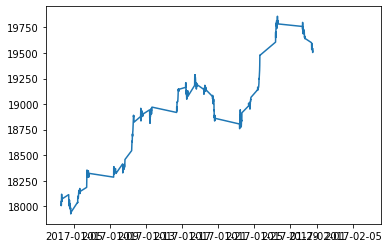

In [24]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(111)


plt.plot(data.iloc[:500,3])


ax1.axvspan(triple_barrier_events.index[0], triple_barrier_events.index[100],18100,18150)

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [25]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       861
           1       0.29      1.00      0.44       344

    accuracy                           0.29      1205
   macro avg       0.14      0.50      0.22      1205
weighted avg       0.08      0.29      0.13      1205

Confusion Matrix
[[  0 861]
 [  0 344]]

Accuracy
0.2854771784232365


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**A few takeaways**
* There is an imbalance in the classes - more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [26]:
raw_data.head()

,open,high,low,close,volume,value,fast_mavg,slow_mavg,side
date_time,,,,,,,,,
2017-01-02 09:19:00,18213.3,18221.8,18160.0,18171.9,140720,2.557150e+09,NaN,NaN,NaN
2017-01-02 09:25:00,18171.9,18171.9,18132.6,18142.9,117800,2.137234e+09,NaN,NaN,NaN
2017-01-02 09:31:00,18142.9,18151.4,18085.0,18085.0,124320,2.248327e+09,NaN,NaN,NaN
2017-01-02 09:34:00,18085.0,18085.0,18052.0,18072.8,140240,2.534529e+09,NaN,NaN,NaN
2017-01-02 09:45:00,18072.8,18097.2,18071.6,18083.3,111800,2.021713e+09,NaN,NaN,NaN


### Features

In [27]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [28]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [29]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [30]:
raw_data.head()

,open,high,low,close,volume,value,fast_mavg,slow_mavg,side,log_ret,...,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
date_time,,,,,,,,,,,,,,,,,,,,,
2017-01-02 09:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 09:25:00,18213.3,18221.8,18160.0,18171.9,140720.0,2.557150e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 09:31:00,18171.9,18171.9,18132.6,18142.9,117800.0,2.137234e+09,NaN,NaN,NaN,-0.001597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 09:34:00,18142.9,18151.4,18085.0,18085.0,124320.0,2.248327e+09,NaN,NaN,NaN,-0.003196,...,NaN,NaN,NaN,NaN,NaN,-0.001597,NaN,NaN,NaN,NaN
2017-01-02 09:45:00,18085.0,18085.0,18052.0,18072.8,140240.0,2.534529e+09,NaN,NaN,NaN,-0.000675,...,NaN,NaN,NaN,NaN,NaN,-0.003196,-0.001597,NaN,NaN,NaN


#### Now get the data at the specified events

In [31]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
# X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)
X.drop(['open', 'high', 'low', 'close', 'fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [32]:
y.value_counts()

0    861
1    344
Name: bin, dtype: int64

In [33]:
labels.index

DatetimeIndex(['2017-01-05 12:17:00', '2017-01-06 09:18:00',
               '2017-01-06 09:28:00', '2017-01-06 10:00:00',
               '2017-01-06 10:50:00', '2017-01-06 13:44:00',
               '2017-01-09 10:39:00', '2017-01-09 14:07:00',
               '2017-01-10 09:19:00', '2017-01-10 09:36:00',
               ...
               '2018-08-28 09:30:00', '2018-08-28 09:40:00',
               '2018-08-28 11:12:00', '2018-08-28 15:03:00',
               '2018-08-29 09:16:00', '2018-08-29 09:22:00',
               '2018-08-30 10:02:00', '2018-08-30 12:25:00',
               '2018-08-30 13:12:00', '2018-08-30 15:09:00'],
              dtype='datetime64[ns]', length=1205, freq=None)

In [34]:
X.index.max()

Timestamp('2018-08-30 15:09:00')

### Balance classes

In [35]:
# Split data into training, validation and test sets
X_training_validation = X['2017-01-01':'2018-04-30']
y_training_validation = y['2017-01-01':'2018-04-30']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.15, shuffle=False)

In [36]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    597
1    248
Name: bin, dtype: int64

In [37]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    597
0    597
Name: bin, dtype: int64

In [38]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

### Fit a model

In [39]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [40]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.5299095  0.59813205 0.638147   0.65097242 0.67273407 0.69076951
 0.68616168 0.54732574 0.66888533 0.70177884 0.71740057 0.73037986
 0.7410691  0.74128315 0.55055666 0.71073293 0.74414953 0.76358999
 0.77308137 0.7806605  0.78307308 0.62648852 0.77841463 0.79303527
 0.81177753 0.81750003 0.82589959 0.83139186 0.67199041 0.83907194
 0.86773667 0.88040036 0.88337377 0.88945855 0.89234847]
512 7 42


In [41]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       597
           1       0.97      0.99      0.98       597

    accuracy                           0.98      1194
   macro avg       0.98      0.98      0.98      1194
weighted avg       0.98      0.98      0.98      1194

Confusion Matrix
[[581  16]
 [  5 592]]

Accuracy
0.9824120603015075


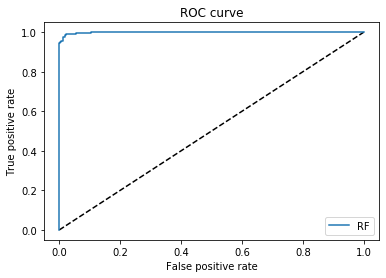

In [42]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       106
           1       0.24      0.18      0.21        44

    accuracy                           0.59       150
   macro avg       0.46      0.47      0.46       150
weighted avg       0.56      0.59      0.57       150

Confusion Matrix
[[80 26]
 [36  8]]

Accuracy
0.5866666666666667


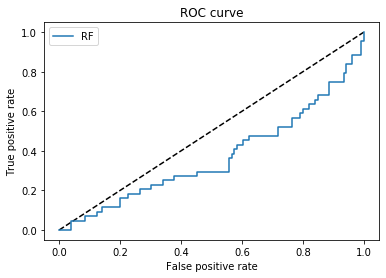

In [43]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [44]:
print(X_validate.index.min())
print(X_validate.index.max())

2018-03-09 13:58:00
2018-04-30 14:36:00


In [45]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(str(X_validate.index.min()))
end = primary_forecast.index.get_loc(str(X_validate.index.max())) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.29      1.00      0.45        44

    accuracy                           0.29       150
   macro avg       0.15      0.50      0.23       150
weighted avg       0.09      0.29      0.13       150

Confusion Matrix
[[  0 106]
 [  0  44]]

Accuracy
0.29333333333333333


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


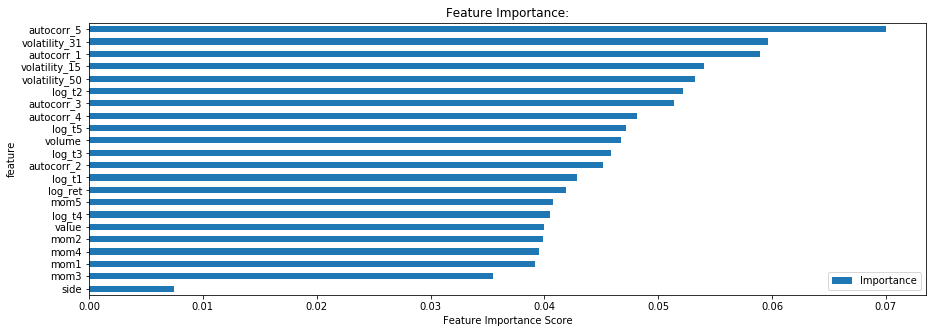

In [46]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

---
## Performance Tear Sheets (In-sample)

### Without Meta Labeling

In [47]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [48]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [49]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [50]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

Start date,2018-03-12
End date,2018-04-30
Total months,1
,Backtest
Annual return,1.7%
Cumulative returns,0.2%
Annual volatility,41.1%
Sharpe ratio,0.24
Calmar ratio,0.14
Stability,0.13
Max drawdown,-12.5%


### With Meta Labeling

In [51]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [52]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2018-03-12
End date,2018-04-30
Total months,1
,Backtest
Annual return,-9.5%
Cumulative returns,-1.4%
Annual volatility,11.7%
Sharpe ratio,-0.80
Calmar ratio,-2.51
Stability,0.29
Max drawdown,-3.8%


---
## Perform out-of-sample test
### Meta Model Metrics

In [53]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-04-30':]
y_oos = y['2018-04-30':]

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       161
           1       0.27      0.27      0.27        52

    accuracy                           0.64       213
   macro avg       0.52      0.52      0.52       213
weighted avg       0.64      0.64      0.64       213

Confusion Matrix
[[123  38]
 [ 38  14]]

Accuracy
0.6431924882629108


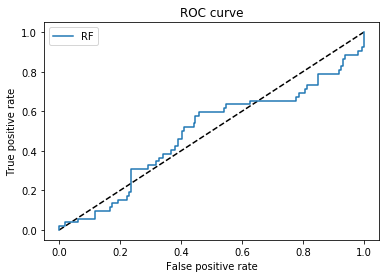

In [54]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [55]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2017-11-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.26      1.00      0.42       174

    accuracy                           0.26       658
   macro avg       0.13      0.50      0.21       658
weighted avg       0.07      0.26      0.11       658

Confusion Matrix
[[  0 484]
 [  0 174]]

Accuracy
0.26443768996960487


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Primary Model (Test Data)

Start date,2018-04-30
End date,2018-08-30
Total months,10
,Backtest
Annual return,-4.1%
Cumulative returns,-3.5%
Annual volatility,10.9%
Sharpe ratio,-0.33
Calmar ratio,-0.21
Stability,0.07
Max drawdown,-19.3%


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.32,2018-06-06,2018-08-30,NaT,NaN
1,11.23,2018-05-28,2018-05-30,2018-06-04,6
2,4.74,2018-05-03,2018-05-15,2018-05-16,10
3,1.48,2018-06-04,2018-06-05,2018-06-05,1
4,1.32,2018-05-16,2018-05-16,2018-05-17,2


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Start date,2018-05-01
End date,2018-08-30
Total months,4
,Backtest
Annual return,-11.3%
Cumulative returns,-4.1%
Annual volatility,25.5%
Sharpe ratio,-0.34
Calmar ratio,-0.58
Stability,0.30
Max drawdown,-19.3%


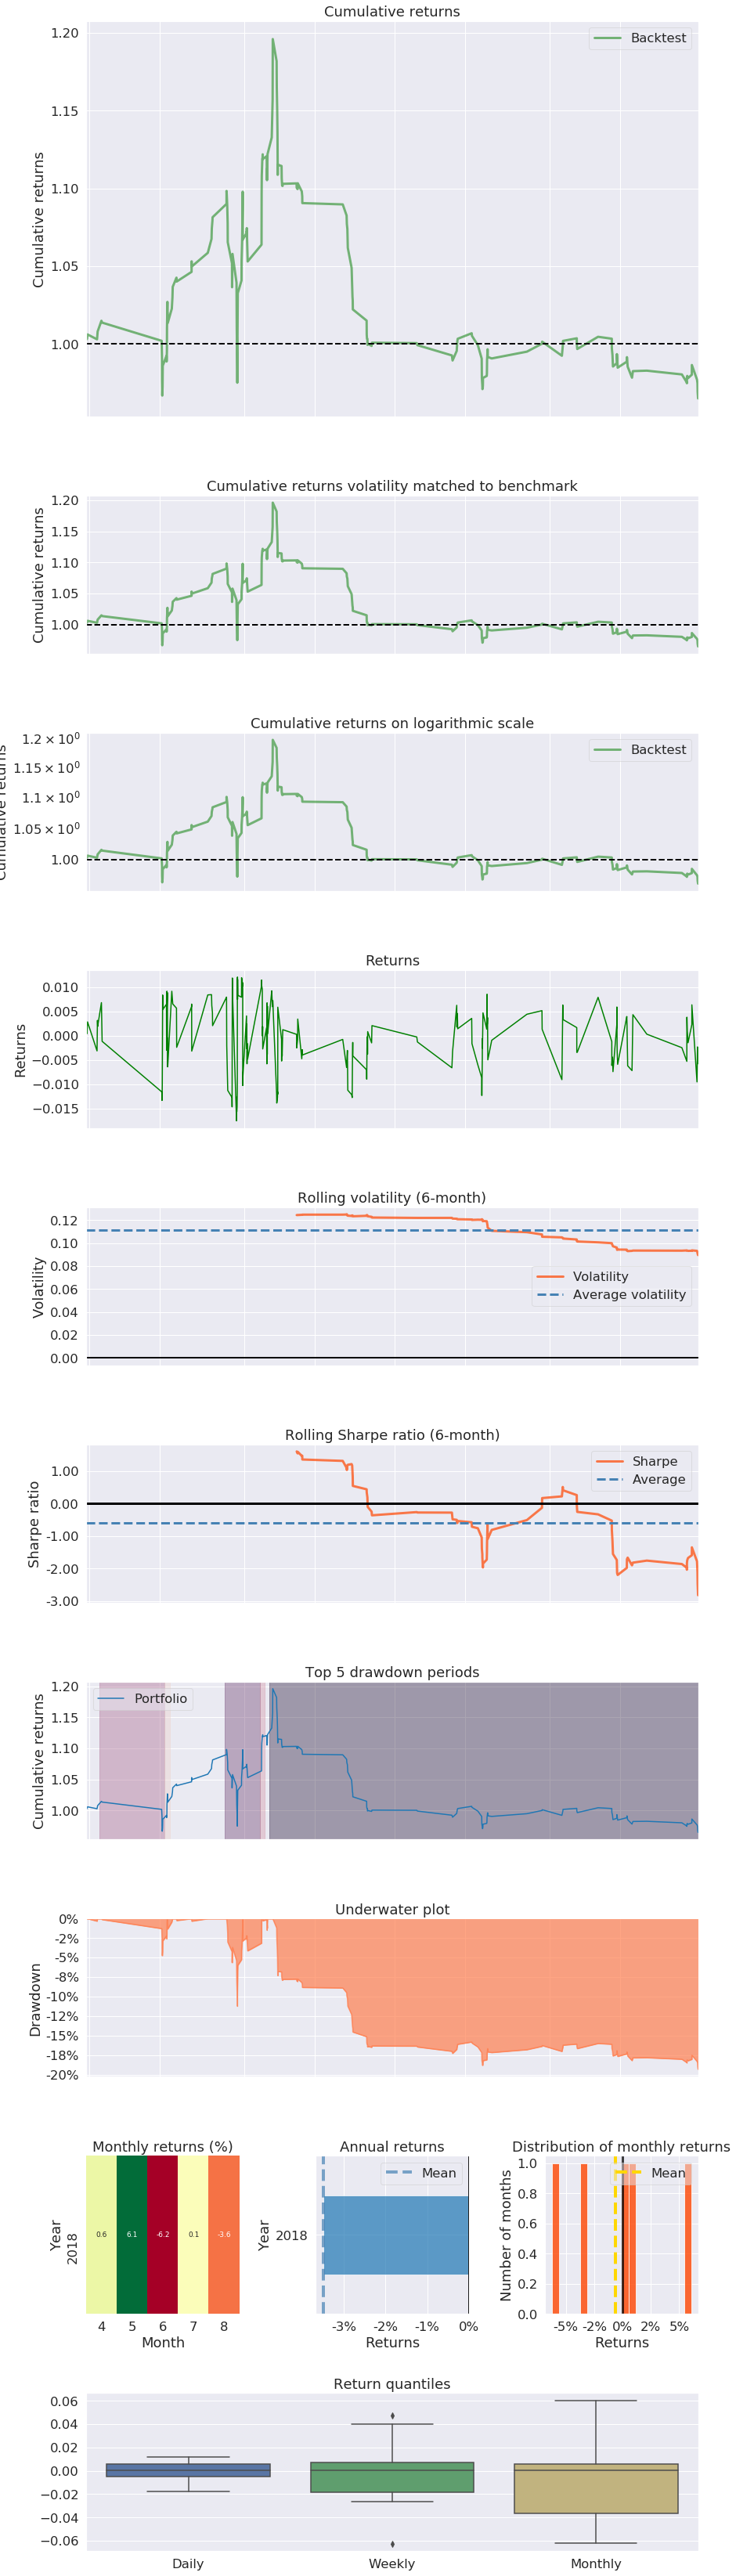

In [56]:
test_dates = X_oos.index

# Downsample to daily
prim_rets_test = labels.loc[test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

## Meta Model (Test Data)

Start date,2018-05-01
End date,2018-08-30
Total months,4
,Backtest
Annual return,-1.0%
Cumulative returns,-0.4%
Annual volatility,8.9%
Sharpe ratio,-0.07
Calmar ratio,-0.18
Stability,0.06
Max drawdown,-5.5%


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.51,2018-06-06,2018-07-18,NaT,NaN
1,1.75,2018-05-29,2018-05-30,2018-06-06,7
2,0.24,2018-05-17,2018-05-18,2018-05-24,6
3,0.00,2018-05-01,2018-05-01,2018-05-01,1
4,0.00,2018-05-01,2018-05-01,2018-05-01,1


C:\Users\as250199\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


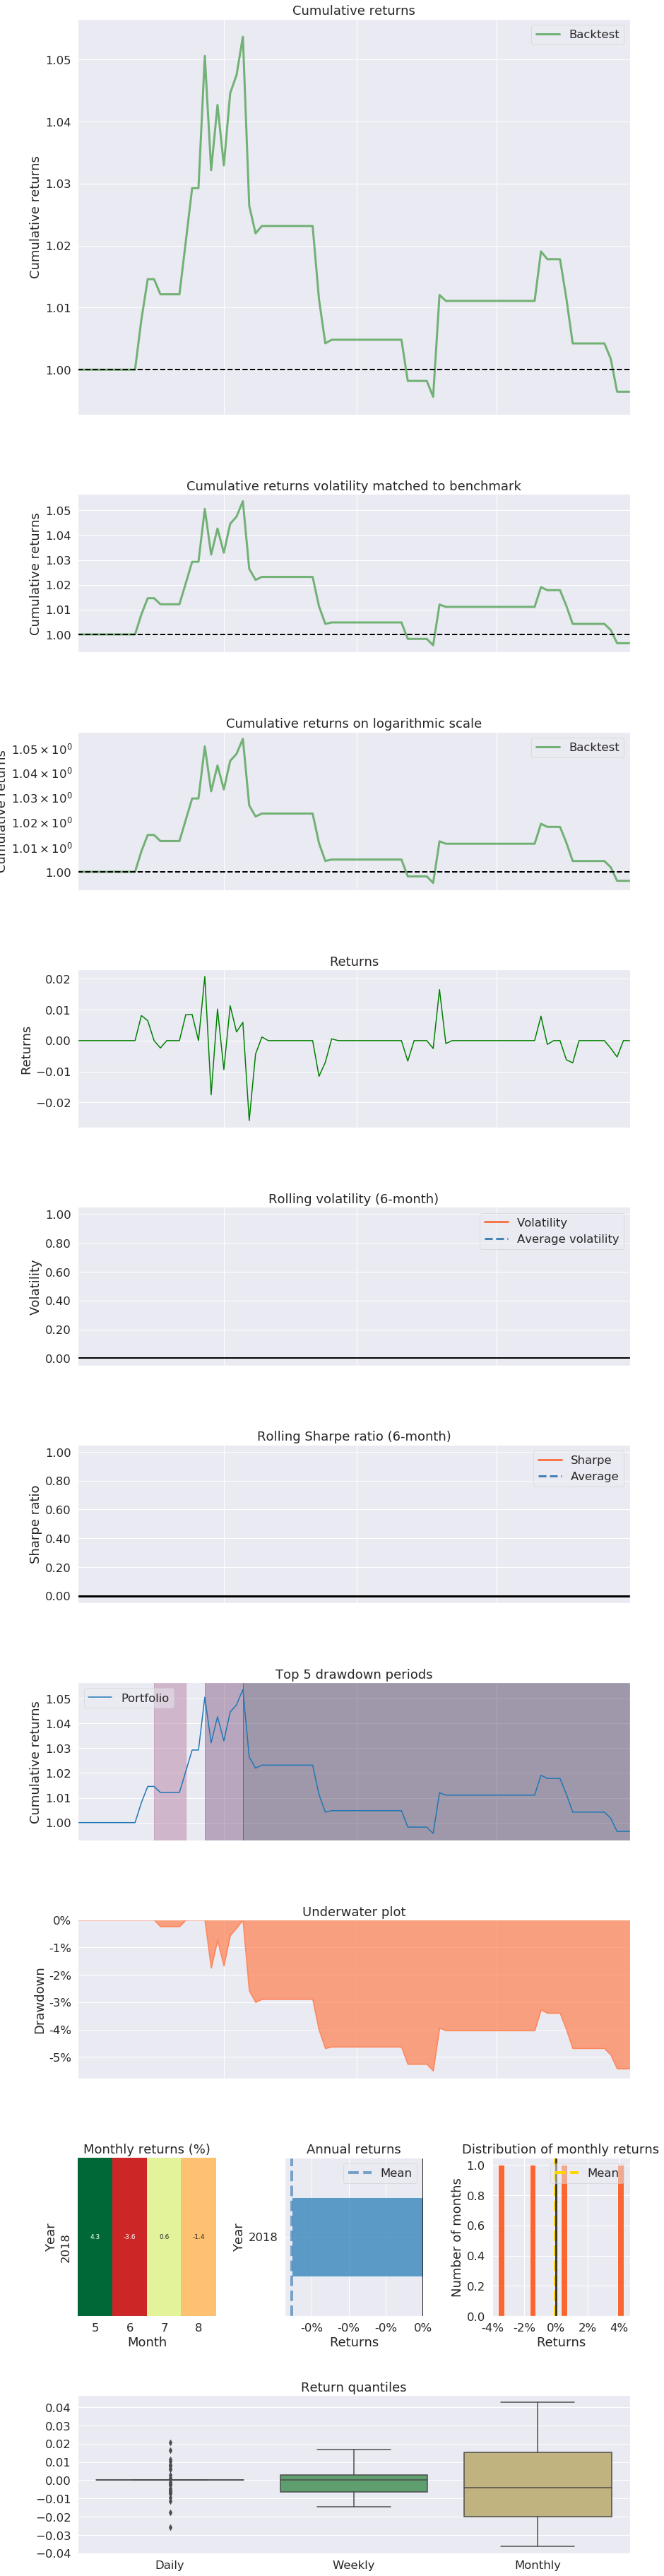

In [57]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)